In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)


In [11]:
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Calculate the date 1 year ago from the last data point in the database
# https://docs.python.org/2/library/datetime.html
end = session.query(measurement.date).order_by(measurement.date.desc()).first()
end_date, = end
year,month,day = end_date.split('-')
date_year_ago = dt.date(int(year),int(month), int(day)) - dt.timedelta(days = 365)
print("Last date in dataset", end_date)
print("Date Year Ago", date_year_ago)

Last date in dataset 2017-08-23
Date Year Ago 2016-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation = session.query(measurement.date, measurement.prcp).filter(measurement.date >= date_year_ago).group_by(measurement.date).all()
#print(precipitation)

In [16]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation)
precipitation_df

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
361,2017-08-19,0.00
362,2017-08-20,0.00
363,2017-08-21,0.00
364,2017-08-22,0.00


         date  prcp
0  2016-08-23  0.00
1  2016-08-24  0.08
2  2016-08-25  0.08
3  2016-08-26  0.00
4  2016-08-27  0.00


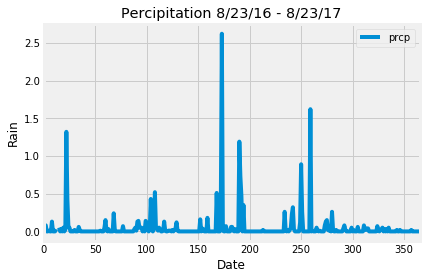

In [17]:
# Sort the dataframe by date
# https://datatofish.com/sort-pandas-dataframe/
precipitation_df.sort_values(["date"])
print(precipitation_df.head())
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.xlabel('Date')
plt.ylabel('Rain')
plt.title('Percipitation 8/23/16 - 8/23/17')
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [19]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(measurement.station).group_by(measurement.station).count()
print(f'There are {number_of_stations} stations in the dataset.')

There are 9 stations in the dataset.


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = session.query(measurement.station,
                               func.count(measurement.tobs))\
                            .group_by(measurement.station)\
                            .order_by(func.count(measurement.tobs).desc()).all()
#List the stations and the counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
high_station = active_stations[0][0]
print(f'{high_station} is the most active station')

USC00519281 is the most active station


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stats = session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).filter(measurement.station == high_station).all()
temp_stats

[(54.0, 71.66378066378067, 85.0)]

In [23]:
print(f"Station: {high_station} results:\n\
    Lowest temperature recorded:  {temp_stats[0][0]}\n\
    Average temperture recorded :  {temp_stats[0][1]}\n\
    Highest temperature recorded:  {temp_stats[0][2]}")

Station: USC00519281 results:
    Lowest temperature recorded:  54.0
    Average temperture recorded :  71.66378066378067
    Highest temperature recorded:  85.0


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
last_12 = session.query(measurement.station, measurement.date, 'measurement.tobs ').\
    filter(measurement.station == high_station).\
    filter(measurement.date > end_date).\
    order_by(measurement.date).all()
last_12_df = pd.DataFrame(last_12)
last_12_df

""


In [25]:
last_12 = session.query(measurement.tobs).filter(measurement.date > date_year_ago).filter(measurement.station == high_station).all()
last_12

[(77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 (69.0),
 (70.0),
 (68.0),
 (69.0),
 (69.0),
 (66.0),
 

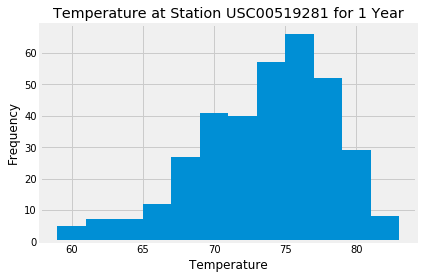

In [26]:
# Plot the results as a histogram
temperature_df = pd.DataFrame(last_12)
temperature_df
plt.hist(temperature_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature at Station USC00519281 for 1 Year")
plt.show()

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# # function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
average_temp_last_12 = calc_temps('2012-02-21', '2012-03-03')
print(average_temp_last_12)

[(64.0, 70.72631578947369, 77.0)]


Text(0, 0.5, 'Temperature (f)')

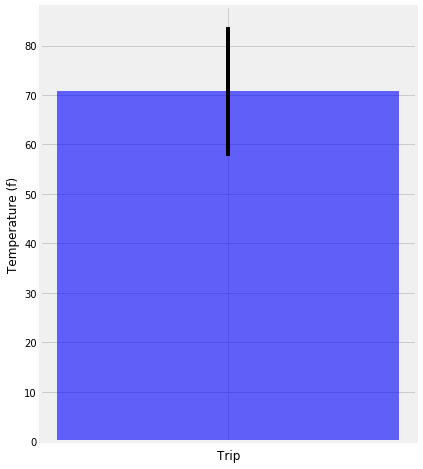

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temps = average_temp_last_12[0][2] - average_temp_last_12[0][0]
avg_temp = average_temp_last_12[0][1]
min_temp = average_temp_last_12[0][0]
max_temp = average_temp_last_12[0][2]

fig, ax = plt.subplots(figsize =(6,8))
bar_chart = ax.bar(1 , avg_temp, color ='blue', tick_label = '', yerr =temps, alpha = 0.6)
ax.set_xlabel("Trip")
ax.set_ylabel('Temperature (f)')


In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_rainfall = session.query(measurement.station, station.name, station.latitude, station.longitude, station.elevation,func.sum(measurement.prcp)).\
    filter(measurement.station == station.station).filter(measurement.date >= date_year_ago).\
    group_by(measurement.station).order_by(func.sum(measurement.prcp).desc()).all()
station_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  147.81000000000006),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  70.03000000000003),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  48.510000000000026),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  38.01),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  33.239999999999995),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  16.089999999999986),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]

In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [48]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = '2020-02-21',
trip_end_date = '2020-03-03'
# Use the start and end date to create a range of dates
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
trip_dates = pd.date_range('2012-02-21', periods=11, freq='D')
# Stip off the year and save a list of %m-%d strings
trip_month_and_day = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normal = []
for date in trip_month_and_day:
    normal.append(*daily_normals(date))
normal

[(63.0, 69.79629629629629, 76.0),
 (60.0, 70.15789473684211, 83.0),
 (62.0, 70.35593220338983, 81.0),
 (61.0, 68.56666666666666, 76.0),
 (61.0, 68.59649122807018, 76.0),
 (62.0, 69.89285714285714, 78.0),
 (58.0, 69.98148148148148, 77.0),
 (65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0)]

In [51]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normal, columns = ['tmin', 'tavg', 'tmax'])
trip_df['date']= trip_dates
trip_df.set_index(['date'], inplace = True)
trip_df.head()

,tmin,tavg,tmax
date,,,
2012-02-21,63.0,69.796296,76.0
2012-02-22,60.0,70.157895,83.0
2012-02-23,62.0,70.355932,81.0
2012-02-24,61.0,68.566667,76.0
2012-02-25,61.0,68.596491,76.0


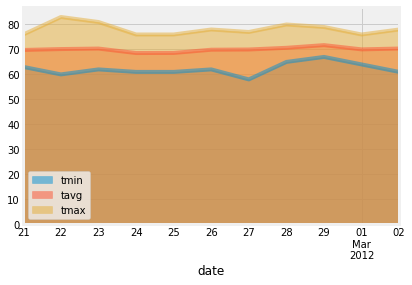

In [52]:
# Plot the daily normals as an area plot with `stacked=False`
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.area.html
trip_df.plot.area(stacked = False)